/Users/dangnguyen/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dangnguyen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dangnguyen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/dangnguyen/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dangnguyen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Naive Bayes Accuracy Score ->  85.12959848190796
SVM Accuracy Score ->  87.73881916591193


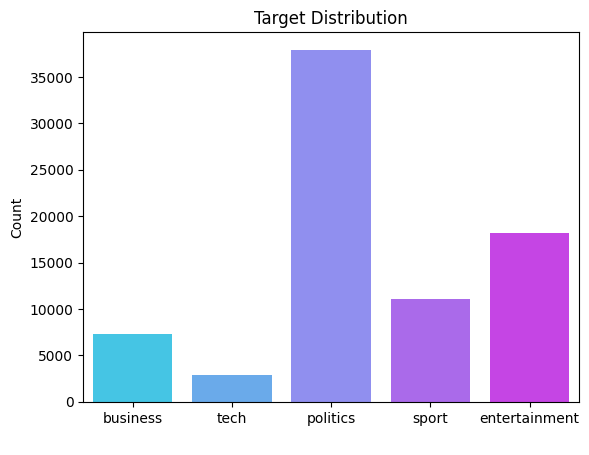

/Users/dangnguyen/Library/Python/3.9/lib/python/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/dangnguyen/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.80      0.66      0.72      2174
           1       0.89      0.90      0.89      5483
           2       0.90      0.95      0.92     11405
           3       0.93      0.90      0.92      3272
           4       0.83      0.59      0.69       853

    accuracy                           0.89     23187
   macro avg       0.87      0.80      0.83     23187
weighted avg       0.89      0.89      0.89     23187

Files saved to disk! Proceed to inference.py


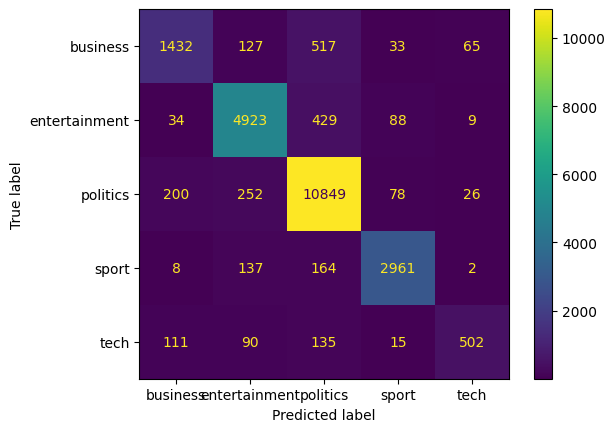

In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
import pickle
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import string
from spacy.lang.en.stop_words import STOP_WORDS
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import re

nltk.download("wordnet")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("stopwords")
# Set Random
np.random.seed(500)

# Thêm đường dẫn pandas

Corpus = pd.read_csv(
    r"/Users/dangnguyen/Documents/Project/Text-Classification/BBCNewsTrain2.csv",
    encoding="latin-1",
)

# Step - 1: Tiền xử lý dữ liệu

# Step - 1a : Xoá các hàng trống
Corpus["text"].dropna(inplace=True)

# WordNetLemmatizer : Xác định danh , tính ,động từ
tag_map = defaultdict(lambda: wn.NOUN)
tag_map["J"] = wn.ADJ
tag_map["V"] = wn.VERB
tag_map["R"] = wn.ADV


def text_preprocessing(text):
    # Step - 1b : Chuyển toàn bộ văn bản sang chữ thường
    text = str(text)
    text = text.lower().replace('\n', ' ').replace('\r', '').strip()
    text = re.sub(' +', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)

    # Step - 1c : Tokenization
    text_words_list = word_tokenize(text)

    # Step - 1d : Làm sạch từ
    # Khai báo các biến để lưu
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # Kiểm tra danh tính động từ
    for word, tag in pos_tag(text_words_list):
        # Lưu ý chỉ xem xét bảng chữ cái English là alpha
        if word not in stopwords.words("english") and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
            Final_words.append(word_Final)
    return str(Final_words)


Corpus["text_final"] = Corpus["text"].map(text_preprocessing)

# Step - 2: Chia mô hình thành tập dữ liệu để huấn luyện
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(
    Corpus["text_final"], Corpus["label"], test_size=0.3
)

# Step - 3: Mã hoá mục tiêu
Encoder = LabelEncoder()
Encoder.fit(Train_Y)
Train_Y = Encoder.transform(Train_Y)
Test_Y = Encoder.transform(Test_Y)

# Step - 4: Vectorize the words by using TF-IDF Vectorizer - Chuyển hoá vector
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(Corpus["text_final"])

Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

# Step - 5: Chạy bộ thuật toán
# Classifier - Algorithm - Naive Bayes
# Huấn luyện bộ dữ liệu
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf, Train_Y)


# Gán nhãn cho tập dữ liệu
predictions_NB = Naive.predict(Test_X_Tfidf)

# Dùng hàm accuracy_score => Lấy độ chính xác
print("Naive Bayes Accuracy Score -> ",
      accuracy_score(predictions_NB, Test_Y) * 100)

# Classifier - Algorithm - SVM
# Huấn luyện bộ dữ liệu trên phân loại
SVM = svm.SVC(C=1.0, kernel="linear", degree=3, gamma="auto")
SVM.fit(Train_X_Tfidf, Train_Y)

# Gán nhãn => predict
predictions_SVM = SVM.predict(Test_X_Tfidf)


# Accuracy_score => accuracy
print("SVM Accuracy Score -> ", accuracy_score(predictions_SVM, Test_Y) * 100)

# Start Ve bieu do
# sns.countplot(x='label', data=Corpus, palette='Blues')
sns.countplot(x='label', data=Corpus, hue='label',
              palette='cool', legend=False)
plt.xlabel(' ')
plt.ylabel('Count')
plt.title('Target Distribution')
plt.show()


def remove_punct(text):

    punctuations = string.punctuation
    mytokens = ''.join(word for word in text if word not in punctuations)

    return mytokens


nlp = spacy.load("en_core_web_lg")
nlp.max_length = 19461259


def tokenization(text):

    token = nlp(text)

    # lemma
    token = [word.lemma_ for word in token]

    # convert tokens into lower case
    token = [word.lower() for word in token]

    return token


def remove_stopwords(text):

    # gives us list stopword in english
    stop_words = spacy.lang.en.stop_words.STOP_WORDS

    # add more stop if requried based on domain knowledge
    #  stop_words + = ['remove','item','rich']

    mytokens = [word for word in text if word not in stop_words]

    return mytokens


def text_norm(text):

    punct_text = remove_punct(text)

    tokens = tokenization(punct_text)

    final_tokens = remove_stopwords(tokens)

    return final_tokens


tf_idf = TfidfVectorizer(min_df=2, max_df=0.90,
                         tokenizer=text_norm, ngram_range=(1, 1))
bow_vectorizer = CountVectorizer(
    tokenizer=text_norm, max_df=0.9, min_df=2, ngram_range=(1, 1))
pipe_bow = Pipeline([('vectorizer', bow_vectorizer),
                    ('classifier', LogisticRegression())])
pipe_tf = Pipeline([
    ('vectorizer', tf_idf),
    ('classifier', LogisticRegression())])

pipe_tf.fit(Train_X, Train_Y)
y_pred_tf = pipe_tf.predict(Test_X)

print(classification_report(Test_Y, y_pred_tf))
ConfusionMatrixDisplay(confusion_matrix(Test_Y, y_pred_tf), display_labels=[
    'business', 'entertainment', 'politics', 'sport', 'tech']).plot()

# End Ve bieu do


# Saving Encdoer, TFIDF Vectorizer

# Lưu bộ mã hoá
filename = "labelencoder_fitted.pkl"
pickle.dump(Encoder, open(filename, "wb"))

# Lưu TFIDF Vectorizer
filename = "Tfidf_vect_fitted.pkl"
pickle.dump(Tfidf_vect, open(filename, "wb"))

# Lưu mô hình
filename = "svm_trained_model.sav"
pickle.dump(SVM, open(filename, "wb"))

filename = "nb_trained_model.sav"
pickle.dump(Naive, open(filename, "wb"))

print("Files saved to disk! Proceed to inference.py")